## Imports

In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization,
                                     Add, Activation, GlobalAveragePooling1D, LayerNormalization,
                                     MultiHeadAttention, Dropout as KDropout,
                                     GRU, Bidirectional)
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

## Data Preparation : Load and Combine Data

In [3]:
# Configs
DATA_PATH = 'G:/Capstone data/karsl-502'
LABELS_PATH = 'G:/Capstone data/KARSL-502_Labels.xlsx'
F_AVG = 30
NUM_FOLDS = 5
BATCH_SIZE = 32
EPOCHS = 12

In [4]:
# Load labels
df_labels = pd.read_excel(LABELS_PATH)
w2id = dict(zip(df_labels['Sign-Arabic'], df_labels['SignID']))
words = list(w2id.keys())
label_map = {word: idx for idx, word in enumerate(words)}
NUM_CLASSES = len(words)

In [5]:
def preprocess_data(data_path, signers, split, f_avg):
    sequences = []
    labels = []
    for word in tqdm(words, desc=f'Loading {split} data for signers {signers}'):
        for signer in signers:
            word_id = w2id[word]
            keypoints_dir = os.path.join(data_path, signer, split, str(word_id).zfill(4))

            required_dirs = ['lh_keypoints', 'rh_keypoints', 'pose_keypoints']
            if not all(os.path.exists(os.path.join(keypoints_dir, d)) for d in required_dirs):
                continue

            lh_dir = os.path.join(keypoints_dir, 'lh_keypoints')
            for sequence in os.listdir(lh_dir):
                try:
                    lh = np.load(os.path.join(lh_dir, sequence))
                    rh = np.load(os.path.join(keypoints_dir, 'rh_keypoints', sequence))
                    pose = np.load(os.path.join(keypoints_dir, 'pose_keypoints', sequence))

                    def pad_sequence(seq):
                        if len(seq) < f_avg:
                            pad = np.tile(seq[-1], (f_avg - len(seq), 1))
                            return np.concatenate([seq, pad])
                        return seq[:f_avg]

                    lh = pad_sequence(lh)
                    rh = pad_sequence(rh)
                    pose = pad_sequence(pose)

                    # Combine pose, lh, rh on last axis (features)
                    combined = np.concatenate([pose, lh, rh], axis=-1)  # shape (f_avg, features)
                    sequences.append(combined)
                    labels.append(label_map[word])
                except Exception as e:
                    print(f"Error loading {sequence}: {e}")

    X = np.array(sequences)
    y = to_categorical(labels, num_classes=NUM_CLASSES)

    return X, y

In [6]:
# Load train and test data
X_train, y_train = preprocess_data(DATA_PATH, ['01', '02','03'], 'train', F_AVG)
X_test, y_test = preprocess_data(DATA_PATH, ['01', '02','03'], 'test', F_AVG)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

Loading train data for signers ['01', '02', '03']: 100%|█████████████████████████████| 502/502 [24:23<00:00,  2.92s/it]
Loading test data for signers ['01', '02', '03']: 100%|██████████████████████████████| 502/502 [04:38<00:00,  1.80it/s]


Shapes:
X_train: (58529, 30, 225) y_train: (58529, 502)
X_test: (11110, 30, 225) y_test: (11110, 502)


## Augmentation Funtion

In [7]:
def augment_data(X, noise_level=0.01):
    """
    Adds Gaussian noise to training data to improve model generalization by
    simulating small variations and reducing overfitting.
    """
    noise = noise_level * np.random.randn(*X.shape)
    return X + noise

## Models

### CNN model

In [10]:
def build_cnn_model(input_shape, num_classes):
    """
    CNN model for sequence classification:
    - One Conv1D layer with BatchNorm and ReLU.
    - MaxPooling and Flatten.
    - Dense layer with dropout before classification.
    """
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(2)(x)
    
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name='CNN_Simple')
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### ViT model

In [12]:
# (Patch embedding + transformer encoder)

In [13]:
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dropout1 = KDropout(rate)
        
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.dropout2 = KDropout(rate)
        
    def call(self, inputs, training=False):
        # PreNorm style
        x_norm = self.layernorm1(inputs)
        attn_output = self.att(x_norm, x_norm)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = inputs + attn_output
        
        out_norm = self.layernorm2(out1)
        ffn_output = self.ffn(out_norm)
        ffn_output = self.dropout2(ffn_output, training=training)
        return out1 + ffn_output

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patches, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.projection = Dense(embed_dim)
        self.position_embedding = self.add_weight(name="pos_embed", shape=(1, num_patches, embed_dim))
    def call(self, patch):
        x = self.projection(patch)
        return x + self.position_embedding

In [14]:

def build_vit_model(input_shape, num_classes, embed_dim=32, num_heads=2, ff_dim=64, num_layers=1, dropout=0.1):
    """
     ViT model for sequence classification:
    - Patch embedding with smaller embedding size.
    - Single Transformer block stating with few number of heads.
    - Global average pooling and dropout before classification.
    """
    inputs = Input(shape=input_shape)
    x = PatchEmbedding(input_shape[0], embed_dim)(inputs)
    for _ in range(num_layers):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout)(x)
    x = GlobalAveragePooling1D()(x)
    x = KDropout(dropout)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name='ViT_Simple')
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### GRU model

In [16]:
def build_gru_model(input_shape, num_classes):
    """
    2-layer GRU model for sequence classification:
    - Two GRU layers with dropout.
    - Dense softmax output layer.
    """
    inputs = Input(shape=input_shape)
    x = GRU(64, return_sequences=True)(inputs)
    x = Dropout(0.3)(x)
    x = GRU(64)(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs, name='GRU_Simple')
    model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

## Training and evaluation

In [19]:
def train_and_evaluate_model(model_name, X_train, y_train, X_test, y_test, NUM_FOLDS=5, EPOCHS=10, BATCH_SIZE=32):
    builders = {
        'CNN': build_cnn_model,
        'ViT': build_vit_model,
        'GRU': build_gru_model  # Replaced BiT with GRU here
    }
    build_fn = builders[model_name]

    input_shape = X_train.shape[1:]
    y_int = np.argmax(y_train, axis=1)

    results = {k: [] for k in ['train_acc', 'val_acc', 'test_acc', 'train_loss', 'val_loss', 'test_loss']}
    best_test_acc = 0
    best_model_path = None

    skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    fold_num = 1

    for train_idx, val_idx in skf.split(X_train, y_int):
        print(f"\nTraining fold {fold_num} / {NUM_FOLDS} for {model_name}")
        X_tr, X_val = X_train[train_idx], X_train[val_idx]
        y_tr, y_val = y_train[train_idx], y_train[val_idx]

        # Data augmentation on training only
        X_tr_aug = augment_data(X_tr)

        model = build_fn(input_shape, y_train.shape[1])
        if fold_num == 1:
            model.summary()

        checkpoint_path = f"{model_name}_fold{fold_num}.h5"
        checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)
        early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

        history = model.fit(
            X_tr_aug, y_tr,
            validation_data=(X_val, y_val),
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[checkpoint, early_stop],
            verbose=2
        )

        train_loss, train_acc = model.evaluate(X_tr, y_tr, verbose=0)
        val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
        test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)

        print(f"Fold {fold_num} results: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}, test_acc={test_acc:.4f}")

        results['train_acc'].append(train_acc)
        results['val_acc'].append(val_acc)
        results['test_acc'].append(test_acc)
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        results['test_loss'].append(test_loss)

        if val_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_path = checkpoint_path

        fold_num += 1

    print(f"\nBest Test accuracy: {best_test_acc:.4f} from model: {best_model_path}")

    return results, best_model_path

### Train CNN

In [20]:
cnn_results, cnn_best_model = train_and_evaluate_model('CNN', X_train, y_train, X_test, y_test, NUM_FOLDS, EPOCHS, BATCH_SIZE)


Training fold 1 / 5 for CNN


Model: "CNN_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 30, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 30, 32)              │          21,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 32)              │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 30, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 480)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          61,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 502)                 │          64,758 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 148,086 (578.46 KB)

 Trainable params: 148,022 (578.21 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.62635, saving model to CNN_fold1.h5


1464/1464 - 7s - 5ms/step - accuracy: 0.4781 - loss: 2.2549 - val_accuracy: 0.6263 - val_loss: 1.3907
Epoch 2/12

Epoch 2: val_accuracy improved from 0.62635 to 0.80711, saving model to CNN_fold1.h5


1464/1464 - 5s - 4ms/step - accuracy: 0.7945 - loss: 0.7000 - val_accuracy: 0.8071 - val_loss: 0.6391
Epoch 3/12

Epoch 3: val_accuracy did not improve from 0.80711
1464/1464 - 5s - 3ms/step - accuracy: 0.8546 - loss: 0.4704 - val_accuracy: 0.7606 - val_loss: 0.9145
Epoch 4/12

Epoch 4: val_accuracy improved from 0.80711 to 0.84205, saving model to CNN_fold1.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8802 - loss: 0.3854 - val_accuracy: 0.8420 - val_loss: 0.5053
Epoch 5/12

Epoch 5: val_accuracy improved from 0.84205 to 0.90424, saving model to CNN_fold1.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8940 - loss: 0.3418 - val_accuracy: 0.9042 - val_loss: 0.3234
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.90424
1464/1464 - 5s - 3ms/step - accuracy: 0.9017 - loss: 0.3164 - val_accuracy: 0.7649 - val_loss: 0.9553
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.90424
1464/1464 - 5s - 3ms/step - accuracy: 0.9113 - loss: 0.2855 - val_accuracy: 0.8908 - val_loss: 0.3761
Epoch 8/12

Epoch 8: val_accuracy did not improve from 0.90424
1464/1464 - 5s - 3ms/step - accuracy: 0.9180 - loss: 0.2657 - val_accuracy: 0.8104 - val_loss: 0.7420
Fold 1 results: train_acc=0.9147, val_acc=0.9042, test_acc=0.8986

Training fold 2 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.70050, saving model to CNN_fold2.h5


1464/1464 - 7s - 5ms/step - accuracy: 0.4788 - loss: 2.2560 - val_accuracy: 0.7005 - val_loss: 1.0642
Epoch 2/12

Epoch 2: val_accuracy improved from 0.70050 to 0.83487, saving model to CNN_fold2.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.7895 - loss: 0.7193 - val_accuracy: 0.8349 - val_loss: 0.5300
Epoch 3/12

Epoch 3: val_accuracy did not improve from 0.83487
1464/1464 - 5s - 3ms/step - accuracy: 0.8480 - loss: 0.5032 - val_accuracy: 0.7745 - val_loss: 0.8046
Epoch 4/12

Epoch 4: val_accuracy did not improve from 0.83487
1464/1464 - 5s - 3ms/step - accuracy: 0.8794 - loss: 0.3989 - val_accuracy: 0.8061 - val_loss: 0.6043
Epoch 5/12

Epoch 5: val_accuracy improved from 0.83487 to 0.88245, saving model to CNN_fold2.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8918 - loss: 0.3511 - val_accuracy: 0.8825 - val_loss: 0.3834
Epoch 6/12

Epoch 6: val_accuracy improved from 0.88245 to 0.89245, saving model to CNN_fold2.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8999 - loss: 0.3211 - val_accuracy: 0.8924 - val_loss: 0.3431
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.89245
1464/1464 - 5s - 3ms/step - accuracy: 0.9098 - loss: 0.2886 - val_accuracy: 0.8523 - val_loss: 0.5030
Epoch 8/12

Epoch 8: val_accuracy improved from 0.89245 to 0.91141, saving model to CNN_fold2.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9168 - loss: 0.2648 - val_accuracy: 0.9114 - val_loss: 0.2896
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.91141
1464/1464 - 5s - 3ms/step - accuracy: 0.9237 - loss: 0.2484 - val_accuracy: 0.8904 - val_loss: 0.3845
Epoch 10/12

Epoch 10: val_accuracy improved from 0.91141 to 0.91816, saving model to CNN_fold2.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9251 - loss: 0.2350 - val_accuracy: 0.9182 - val_loss: 0.2839
Epoch 11/12

Epoch 11: val_accuracy did not improve from 0.91816
1464/1464 - 5s - 3ms/step - accuracy: 0.9290 - loss: 0.2209 - val_accuracy: 0.9065 - val_loss: 0.3265
Epoch 12/12

Epoch 12: val_accuracy improved from 0.91816 to 0.93362, saving model to CNN_fold2.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9351 - loss: 0.2086 - val_accuracy: 0.9336 - val_loss: 0.2205
Fold 2 results: train_acc=0.9487, val_acc=0.9336, test_acc=0.9328

Training fold 3 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.68674, saving model to CNN_fold3.h5


1464/1464 - 7s - 5ms/step - accuracy: 0.4821 - loss: 2.2424 - val_accuracy: 0.6867 - val_loss: 1.0764
Epoch 2/12

Epoch 2: val_accuracy improved from 0.68674 to 0.82556, saving model to CNN_fold3.h5


1464/1464 - 5s - 4ms/step - accuracy: 0.7978 - loss: 0.6852 - val_accuracy: 0.8256 - val_loss: 0.5852
Epoch 3/12

Epoch 3: val_accuracy improved from 0.82556 to 0.82838, saving model to CNN_fold3.h5


1464/1464 - 5s - 4ms/step - accuracy: 0.8538 - loss: 0.4797 - val_accuracy: 0.8284 - val_loss: 0.5750
Epoch 4/12

Epoch 4: val_accuracy improved from 0.82838 to 0.85298, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8794 - loss: 0.3916 - val_accuracy: 0.8530 - val_loss: 0.5034
Epoch 5/12

Epoch 5: val_accuracy improved from 0.85298 to 0.88297, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8929 - loss: 0.3456 - val_accuracy: 0.8830 - val_loss: 0.4039
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.88297
1464/1464 - 5s - 3ms/step - accuracy: 0.9052 - loss: 0.3058 - val_accuracy: 0.8787 - val_loss: 0.4037
Epoch 7/12

Epoch 7: val_accuracy improved from 0.88297 to 0.89715, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9113 - loss: 0.2816 - val_accuracy: 0.8971 - val_loss: 0.3406
Epoch 8/12

Epoch 8: val_accuracy improved from 0.89715 to 0.90048, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9178 - loss: 0.2636 - val_accuracy: 0.9005 - val_loss: 0.3539
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.90048
1464/1464 - 5s - 3ms/step - accuracy: 0.9233 - loss: 0.2449 - val_accuracy: 0.8848 - val_loss: 0.3947
Epoch 10/12

Epoch 10: val_accuracy improved from 0.90048 to 0.90458, saving model to CNN_fold3.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9275 - loss: 0.2334 - val_accuracy: 0.9046 - val_loss: 0.3515
Epoch 11/12

Epoch 11: val_accuracy did not improve from 0.90458
1464/1464 - 5s - 3ms/step - accuracy: 0.9326 - loss: 0.2141 - val_accuracy: 0.9044 - val_loss: 0.3467
Epoch 12/12

Epoch 12: val_accuracy did not improve from 0.90458
1464/1464 - 5s - 3ms/step - accuracy: 0.9369 - loss: 0.2036 - val_accuracy: 0.8907 - val_loss: 0.4147
Fold 3 results: train_acc=0.9164, val_acc=0.9046, test_acc=0.9021

Training fold 4 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.70639, saving model to CNN_fold4.h5


1464/1464 - 7s - 5ms/step - accuracy: 0.4788 - loss: 2.2572 - val_accuracy: 0.7064 - val_loss: 1.0118
Epoch 2/12

Epoch 2: val_accuracy improved from 0.70639 to 0.76269, saving model to CNN_fold4.h5


1464/1464 - 5s - 4ms/step - accuracy: 0.7978 - loss: 0.6902 - val_accuracy: 0.7627 - val_loss: 0.8211
Epoch 3/12

Epoch 3: val_accuracy improved from 0.76269 to 0.81087, saving model to CNN_fold4.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8512 - loss: 0.4874 - val_accuracy: 0.8109 - val_loss: 0.6271
Epoch 4/12

Epoch 4: val_accuracy improved from 0.81087 to 0.90236, saving model to CNN_fold4.h5


1464/1464 - 5s - 4ms/step - accuracy: 0.8784 - loss: 0.3947 - val_accuracy: 0.9024 - val_loss: 0.3197
Epoch 5/12

Epoch 5: val_accuracy did not improve from 0.90236
1464/1464 - 5s - 3ms/step - accuracy: 0.8970 - loss: 0.3383 - val_accuracy: 0.7957 - val_loss: 0.7765
Epoch 6/12

Epoch 6: val_accuracy did not improve from 0.90236
1464/1464 - 5s - 3ms/step - accuracy: 0.9043 - loss: 0.3067 - val_accuracy: 0.6945 - val_loss: 1.4097
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.90236
1464/1464 - 5s - 3ms/step - accuracy: 0.9126 - loss: 0.2778 - val_accuracy: 0.7968 - val_loss: 0.7906
Fold 4 results: train_acc=0.9134, val_acc=0.9024, test_acc=0.8960

Training fold 5 / 5 for CNN
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.69654, saving model to CNN_fold5.h5


1464/1464 - 7s - 5ms/step - accuracy: 0.4835 - loss: 2.2499 - val_accuracy: 0.6965 - val_loss: 1.0689
Epoch 2/12

Epoch 2: val_accuracy improved from 0.69654 to 0.76121, saving model to CNN_fold5.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.7940 - loss: 0.6961 - val_accuracy: 0.7612 - val_loss: 0.8186
Epoch 3/12

Epoch 3: val_accuracy improved from 0.76121 to 0.84887, saving model to CNN_fold5.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.8549 - loss: 0.4783 - val_accuracy: 0.8489 - val_loss: 0.5026
Epoch 4/12

Epoch 4: val_accuracy did not improve from 0.84887
1464/1464 - 5s - 3ms/step - accuracy: 0.8770 - loss: 0.3970 - val_accuracy: 0.8178 - val_loss: 0.6502
Epoch 5/12

Epoch 5: val_accuracy did not improve from 0.84887
1464/1464 - 5s - 3ms/step - accuracy: 0.8947 - loss: 0.3469 - val_accuracy: 0.7988 - val_loss: 0.8067
Epoch 6/12

Epoch 6: val_accuracy improved from 0.84887 to 0.90184, saving model to CNN_fold5.h5


1464/1464 - 5s - 3ms/step - accuracy: 0.9028 - loss: 0.3101 - val_accuracy: 0.9018 - val_loss: 0.3231
Epoch 7/12

Epoch 7: val_accuracy did not improve from 0.90184
1464/1464 - 5s - 3ms/step - accuracy: 0.9091 - loss: 0.2887 - val_accuracy: 0.8826 - val_loss: 0.4015
Epoch 8/12

Epoch 8: val_accuracy did not improve from 0.90184
1464/1464 - 4s - 3ms/step - accuracy: 0.9162 - loss: 0.2686 - val_accuracy: 0.8240 - val_loss: 0.6675
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.90184
1464/1464 - 5s - 3ms/step - accuracy: 0.9199 - loss: 0.2515 - val_accuracy: 0.8884 - val_loss: 0.4126
Fold 5 results: train_acc=0.9180, val_acc=0.9018, test_acc=0.9037

Best Test accuracy: 0.9328 from model: CNN_fold2.h5


### Train GRU

In [22]:
gru_results, gru_best_model = train_and_evaluate_model('GRU', X_train, y_train, X_test, y_test, NUM_FOLDS, EPOCHS, BATCH_SIZE)


Training fold 1 / 5 for GRU


Model: "GRU_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 30, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ (None, 30, 64)              │          55,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 502)                 │          32,630 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 113,462 (443.21 KB)

 Trainable params: 113,462 (443.21 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.27541, saving model to GRU_fold1.h5


1464/1464 - 23s - 16ms/step - accuracy: 0.0889 - loss: 4.6354 - val_accuracy: 0.2754 - val_loss: 3.3393
Epoch 2/12

Epoch 2: val_accuracy improved from 0.27541 to 0.52580, saving model to GRU_fold1.h5


1464/1464 - 20s - 14ms/step - accuracy: 0.3447 - loss: 2.8107 - val_accuracy: 0.5258 - val_loss: 2.0771
Epoch 3/12

Epoch 3: val_accuracy improved from 0.52580 to 0.64514, saving model to GRU_fold1.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.5045 - loss: 1.9864 - val_accuracy: 0.6451 - val_loss: 1.4758
Epoch 4/12

Epoch 4: val_accuracy improved from 0.64514 to 0.69563, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.5949 - loss: 1.5549 - val_accuracy: 0.6956 - val_loss: 1.1735
Epoch 5/12

Epoch 5: val_accuracy improved from 0.69563 to 0.76345, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6561 - loss: 1.2804 - val_accuracy: 0.7635 - val_loss: 0.9103
Epoch 6/12

Epoch 6: val_accuracy improved from 0.76345 to 0.76858, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6999 - loss: 1.0961 - val_accuracy: 0.7686 - val_loss: 0.8461
Epoch 7/12

Epoch 7: val_accuracy improved from 0.76858 to 0.81813, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7303 - loss: 0.9612 - val_accuracy: 0.8181 - val_loss: 0.6797
Epoch 8/12

Epoch 8: val_accuracy improved from 0.81813 to 0.84333, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7566 - loss: 0.8487 - val_accuracy: 0.8433 - val_loss: 0.5726
Epoch 9/12

Epoch 9: val_accuracy improved from 0.84333 to 0.85930, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7744 - loss: 0.7813 - val_accuracy: 0.8593 - val_loss: 0.5069
Epoch 10/12

Epoch 10: val_accuracy improved from 0.85930 to 0.87946, saving model to GRU_fold1.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7953 - loss: 0.7013 - val_accuracy: 0.8795 - val_loss: 0.4367
Epoch 11/12

Epoch 11: val_accuracy did not improve from 0.87946
1464/1464 - 21s - 14ms/step - accuracy: 0.8093 - loss: 0.6466 - val_accuracy: 0.8756 - val_loss: 0.4234
Epoch 12/12

Epoch 12: val_accuracy improved from 0.87946 to 0.89091, saving model to GRU_fold1.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.8234 - loss: 0.5980 - val_accuracy: 0.8909 - val_loss: 0.3847
Fold 1 results: train_acc=0.9045, val_acc=0.8909, test_acc=0.8906

Training fold 2 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.29831, saving model to GRU_fold2.h5


1464/1464 - 26s - 18ms/step - accuracy: 0.0944 - loss: 4.5695 - val_accuracy: 0.2983 - val_loss: 3.2108
Epoch 2/12

Epoch 2: val_accuracy improved from 0.29831 to 0.51179, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.3451 - loss: 2.7569 - val_accuracy: 0.5118 - val_loss: 2.0663
Epoch 3/12

Epoch 3: val_accuracy improved from 0.51179 to 0.62848, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.5025 - loss: 1.9736 - val_accuracy: 0.6285 - val_loss: 1.4807
Epoch 4/12

Epoch 4: val_accuracy improved from 0.62848 to 0.72535, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.5967 - loss: 1.5502 - val_accuracy: 0.7254 - val_loss: 1.1096
Epoch 5/12

Epoch 5: val_accuracy improved from 0.72535 to 0.76166, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6589 - loss: 1.2726 - val_accuracy: 0.7617 - val_loss: 0.9153
Epoch 6/12

Epoch 6: val_accuracy improved from 0.76166 to 0.79156, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6965 - loss: 1.0967 - val_accuracy: 0.7916 - val_loss: 0.7718
Epoch 7/12

Epoch 7: val_accuracy improved from 0.79156 to 0.81257, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7297 - loss: 0.9686 - val_accuracy: 0.8126 - val_loss: 0.6799
Epoch 8/12

Epoch 8: val_accuracy improved from 0.81257 to 0.84145, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7554 - loss: 0.8583 - val_accuracy: 0.8414 - val_loss: 0.5808
Epoch 9/12

Epoch 9: val_accuracy did not improve from 0.84145
1464/1464 - 21s - 14ms/step - accuracy: 0.7758 - loss: 0.7777 - val_accuracy: 0.8394 - val_loss: 0.5559
Epoch 10/12

Epoch 10: val_accuracy improved from 0.84145 to 0.86955, saving model to GRU_fold2.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.7847 - loss: 0.7391 - val_accuracy: 0.8696 - val_loss: 0.4668
Epoch 11/12

Epoch 11: val_accuracy improved from 0.86955 to 0.87750, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8086 - loss: 0.6536 - val_accuracy: 0.8775 - val_loss: 0.4267
Epoch 12/12

Epoch 12: val_accuracy improved from 0.87750 to 0.88544, saving model to GRU_fold2.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7922 - loss: 0.7282 - val_accuracy: 0.8854 - val_loss: 0.3925
Fold 2 results: train_acc=0.9041, val_acc=0.8854, test_acc=0.8867

Training fold 3 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.28473, saving model to GRU_fold3.h5


1464/1464 - 28s - 19ms/step - accuracy: 0.0933 - loss: 4.5542 - val_accuracy: 0.2847 - val_loss: 3.2595
Epoch 2/12

Epoch 2: val_accuracy improved from 0.28473 to 0.52964, saving model to GRU_fold3.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.3483 - loss: 2.7893 - val_accuracy: 0.5296 - val_loss: 2.0645
Epoch 3/12

Epoch 3: val_accuracy improved from 0.52964 to 0.63361, saving model to GRU_fold3.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.5138 - loss: 1.9592 - val_accuracy: 0.6336 - val_loss: 1.4986
Epoch 4/12

Epoch 4: val_accuracy improved from 0.63361 to 0.73612, saving model to GRU_fold3.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.6053 - loss: 1.5151 - val_accuracy: 0.7361 - val_loss: 1.0855
Epoch 5/12

Epoch 5: val_accuracy improved from 0.73612 to 0.76269, saving model to GRU_fold3.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.6685 - loss: 1.2329 - val_accuracy: 0.7627 - val_loss: 0.9013
Epoch 6/12

Epoch 6: val_accuracy improved from 0.76269 to 0.81155, saving model to GRU_fold3.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.7122 - loss: 1.0415 - val_accuracy: 0.8115 - val_loss: 0.7235
Epoch 7/12

Epoch 7: val_accuracy improved from 0.81155 to 0.82385, saving model to GRU_fold3.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7445 - loss: 0.9104 - val_accuracy: 0.8239 - val_loss: 0.6380
Epoch 8/12

Epoch 8: val_accuracy improved from 0.82385 to 0.84982, saving model to GRU_fold3.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.7663 - loss: 0.8178 - val_accuracy: 0.8498 - val_loss: 0.5386
Epoch 9/12

Epoch 9: val_accuracy improved from 0.84982 to 0.86810, saving model to GRU_fold3.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7858 - loss: 0.7420 - val_accuracy: 0.8681 - val_loss: 0.4748
Epoch 10/12

Epoch 10: val_accuracy improved from 0.86810 to 0.87775, saving model to GRU_fold3.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.7948 - loss: 0.7016 - val_accuracy: 0.8778 - val_loss: 0.4216
Epoch 11/12

Epoch 11: val_accuracy improved from 0.87775 to 0.88168, saving model to GRU_fold3.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.8130 - loss: 0.6374 - val_accuracy: 0.8817 - val_loss: 0.4119
Epoch 12/12

Epoch 12: val_accuracy improved from 0.88168 to 0.89100, saving model to GRU_fold3.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.8271 - loss: 0.5831 - val_accuracy: 0.8910 - val_loss: 0.3725
Fold 3 results: train_acc=0.9109, val_acc=0.8910, test_acc=0.8947

Training fold 4 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.24654, saving model to GRU_fold4.h5


1464/1464 - 25s - 17ms/step - accuracy: 0.0793 - loss: 4.6344 - val_accuracy: 0.2465 - val_loss: 3.4299
Epoch 2/12

Epoch 2: val_accuracy improved from 0.24654 to 0.46984, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.3060 - loss: 2.9677 - val_accuracy: 0.4698 - val_loss: 2.2592
Epoch 3/12

Epoch 3: val_accuracy improved from 0.46984 to 0.61379, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.4688 - loss: 2.1211 - val_accuracy: 0.6138 - val_loss: 1.6132
Epoch 4/12

Epoch 4: val_accuracy improved from 0.61379 to 0.67025, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.5616 - loss: 1.6655 - val_accuracy: 0.6703 - val_loss: 1.3230
Epoch 5/12

Epoch 5: val_accuracy improved from 0.67025 to 0.74782, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6300 - loss: 1.3716 - val_accuracy: 0.7478 - val_loss: 0.9833
Epoch 6/12

Epoch 6: val_accuracy improved from 0.74782 to 0.78772, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.6770 - loss: 1.1732 - val_accuracy: 0.7877 - val_loss: 0.8150
Epoch 7/12

Epoch 7: val_accuracy improved from 0.78772 to 0.80617, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7156 - loss: 1.0198 - val_accuracy: 0.8062 - val_loss: 0.7330
Epoch 8/12

Epoch 8: val_accuracy improved from 0.80617 to 0.84461, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7424 - loss: 0.9027 - val_accuracy: 0.8446 - val_loss: 0.5944
Epoch 9/12

Epoch 9: val_accuracy improved from 0.84461 to 0.85537, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7700 - loss: 0.8011 - val_accuracy: 0.8554 - val_loss: 0.5362
Epoch 10/12

Epoch 10: val_accuracy improved from 0.85537 to 0.85777, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.7854 - loss: 0.7390 - val_accuracy: 0.8578 - val_loss: 0.4948
Epoch 11/12

Epoch 11: val_accuracy improved from 0.85777 to 0.86870, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8005 - loss: 0.6802 - val_accuracy: 0.8687 - val_loss: 0.4571
Epoch 12/12

Epoch 12: val_accuracy improved from 0.86870 to 0.88912, saving model to GRU_fold4.h5


1464/1464 - 21s - 14ms/step - accuracy: 0.8163 - loss: 0.6308 - val_accuracy: 0.8891 - val_loss: 0.3879
Fold 4 results: train_acc=0.9061, val_acc=0.8891, test_acc=0.8926

Training fold 5 / 5 for GRU
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.25989, saving model to GRU_fold5.h5


1464/1464 - 27s - 18ms/step - accuracy: 0.0917 - loss: 4.5173 - val_accuracy: 0.2599 - val_loss: 3.3148
Epoch 2/12

Epoch 2: val_accuracy improved from 0.25989 to 0.50243, saving model to GRU_fold5.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.3292 - loss: 2.8358 - val_accuracy: 0.5024 - val_loss: 2.1799
Epoch 3/12

Epoch 3: val_accuracy improved from 0.50243 to 0.65468, saving model to GRU_fold5.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.4932 - loss: 2.0366 - val_accuracy: 0.6547 - val_loss: 1.4928
Epoch 4/12

Epoch 4: val_accuracy improved from 0.65468 to 0.70807, saving model to GRU_fold5.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.5892 - loss: 1.5786 - val_accuracy: 0.7081 - val_loss: 1.1615
Epoch 5/12

Epoch 5: val_accuracy improved from 0.70807 to 0.72918, saving model to GRU_fold5.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.6508 - loss: 1.2957 - val_accuracy: 0.7292 - val_loss: 1.0363
Epoch 6/12

Epoch 6: val_accuracy improved from 0.72918 to 0.79863, saving model to GRU_fold5.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.6898 - loss: 1.1251 - val_accuracy: 0.7986 - val_loss: 0.7467
Epoch 7/12

Epoch 7: val_accuracy improved from 0.79863 to 0.82512, saving model to GRU_fold5.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.7311 - loss: 0.9578 - val_accuracy: 0.8251 - val_loss: 0.6354
Epoch 8/12

Epoch 8: val_accuracy improved from 0.82512 to 0.84169, saving model to GRU_fold5.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.7522 - loss: 0.8632 - val_accuracy: 0.8417 - val_loss: 0.5742
Epoch 9/12

Epoch 9: val_accuracy improved from 0.84169 to 0.85587, saving model to GRU_fold5.h5


1464/1464 - 23s - 16ms/step - accuracy: 0.7752 - loss: 0.7748 - val_accuracy: 0.8559 - val_loss: 0.5111
Epoch 10/12

Epoch 10: val_accuracy improved from 0.85587 to 0.86946, saving model to GRU_fold5.h5


1464/1464 - 23s - 16ms/step - accuracy: 0.7881 - loss: 0.7216 - val_accuracy: 0.8695 - val_loss: 0.4560
Epoch 11/12

Epoch 11: val_accuracy improved from 0.86946 to 0.88176, saving model to GRU_fold5.h5


1464/1464 - 22s - 15ms/step - accuracy: 0.8020 - loss: 0.6746 - val_accuracy: 0.8818 - val_loss: 0.4190
Epoch 12/12

Epoch 12: val_accuracy improved from 0.88176 to 0.88347, saving model to GRU_fold5.h5


1464/1464 - 21s - 15ms/step - accuracy: 0.8189 - loss: 0.6052 - val_accuracy: 0.8835 - val_loss: 0.4034
Fold 5 results: train_acc=0.8989, val_acc=0.8835, test_acc=0.8814

Best Test accuracy: 0.8947 from model: GRU_fold3.h5


### Train ViT

In [21]:
vit_results, vit_best_model = train_and_evaluate_model('ViT', X_train, y_train, X_test, y_test, NUM_FOLDS, EPOCHS, BATCH_SIZE)


Training fold 1 / 5 for ViT



Model: "ViT_Simple"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 30, 225)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ patch_embedding (PatchEmbedding)     │ (None, 30, 32)              │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_block (TransformerBlock) │ (None, 30, 32)              │          12,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 502)                 │          16,566 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,494 (146.46 KB)

 Trainable params: 37,494 (146.46 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.03631, saving model to ViT_fold1.h5


1464/1464 - 12s - 8ms/step - accuracy: 0.0097 - loss: 5.8175 - val_accuracy: 0.0363 - val_loss: 5.1744
Epoch 2/12

Epoch 2: val_accuracy improved from 0.03631 to 0.11763, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.0480 - loss: 4.7509 - val_accuracy: 0.1176 - val_loss: 4.1685
Epoch 3/12

Epoch 3: val_accuracy improved from 0.11763 to 0.23586, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1142 - loss: 3.9888 - val_accuracy: 0.2359 - val_loss: 3.4497
Epoch 4/12

Epoch 4: val_accuracy improved from 0.23586 to 0.31727, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1779 - loss: 3.4448 - val_accuracy: 0.3173 - val_loss: 2.9441
Epoch 5/12

Epoch 5: val_accuracy improved from 0.31727 to 0.39604, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2391 - loss: 3.0442 - val_accuracy: 0.3960 - val_loss: 2.5628
Epoch 6/12

Epoch 6: val_accuracy improved from 0.39604 to 0.44584, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2945 - loss: 2.7293 - val_accuracy: 0.4458 - val_loss: 2.2809
Epoch 7/12

Epoch 7: val_accuracy improved from 0.44584 to 0.50026, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3454 - loss: 2.4758 - val_accuracy: 0.5003 - val_loss: 2.0451
Epoch 8/12

Epoch 8: val_accuracy improved from 0.50026 to 0.53656, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3901 - loss: 2.2734 - val_accuracy: 0.5366 - val_loss: 1.8605
Epoch 9/12

Epoch 9: val_accuracy improved from 0.53656 to 0.57167, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4257 - loss: 2.1147 - val_accuracy: 0.5717 - val_loss: 1.7110
Epoch 10/12

Epoch 10: val_accuracy improved from 0.57167 to 0.59747, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4582 - loss: 1.9686 - val_accuracy: 0.5975 - val_loss: 1.5926
Epoch 11/12

Epoch 11: val_accuracy improved from 0.59747 to 0.61746, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4864 - loss: 1.8454 - val_accuracy: 0.6175 - val_loss: 1.4840
Epoch 12/12

Epoch 12: val_accuracy improved from 0.61746 to 0.64138, saving model to ViT_fold1.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5151 - loss: 1.7280 - val_accuracy: 0.6414 - val_loss: 1.3916
Fold 1 results: train_acc=0.6531, val_acc=0.6414, test_acc=0.6419

Training fold 2 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.03673, saving model to ViT_fold2.h5


1464/1464 - 13s - 9ms/step - accuracy: 0.0102 - loss: 5.8406 - val_accuracy: 0.0367 - val_loss: 5.2326
Epoch 2/12

Epoch 2: val_accuracy improved from 0.03673 to 0.13438, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.0563 - loss: 4.7332 - val_accuracy: 0.1344 - val_loss: 4.1307
Epoch 3/12

Epoch 3: val_accuracy improved from 0.13438 to 0.24500, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1256 - loss: 3.8915 - val_accuracy: 0.2450 - val_loss: 3.3598
Epoch 4/12

Epoch 4: val_accuracy improved from 0.24500 to 0.33325, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1984 - loss: 3.3411 - val_accuracy: 0.3332 - val_loss: 2.8530
Epoch 5/12

Epoch 5: val_accuracy improved from 0.33325 to 0.39757, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2562 - loss: 2.9653 - val_accuracy: 0.3976 - val_loss: 2.5067
Epoch 6/12

Epoch 6: val_accuracy improved from 0.39757 to 0.44336, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3088 - loss: 2.6710 - val_accuracy: 0.4434 - val_loss: 2.2430
Epoch 7/12

Epoch 7: val_accuracy improved from 0.44336 to 0.50786, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3530 - loss: 2.4416 - val_accuracy: 0.5079 - val_loss: 2.0185
Epoch 8/12

Epoch 8: val_accuracy improved from 0.50786 to 0.53596, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3965 - loss: 2.2328 - val_accuracy: 0.5360 - val_loss: 1.8383
Epoch 9/12

Epoch 9: val_accuracy improved from 0.53596 to 0.58414, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4391 - loss: 2.0504 - val_accuracy: 0.5841 - val_loss: 1.6661
Epoch 10/12

Epoch 10: val_accuracy improved from 0.58414 to 0.61755, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4826 - loss: 1.8802 - val_accuracy: 0.6175 - val_loss: 1.5146
Epoch 11/12

Epoch 11: val_accuracy improved from 0.61755 to 0.64411, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5198 - loss: 1.7347 - val_accuracy: 0.6441 - val_loss: 1.3833
Epoch 12/12

Epoch 12: val_accuracy improved from 0.64411 to 0.67589, saving model to ViT_fold2.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5512 - loss: 1.5989 - val_accuracy: 0.6759 - val_loss: 1.2623
Fold 2 results: train_acc=0.6984, val_acc=0.6759, test_acc=0.6921

Training fold 3 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.03152, saving model to ViT_fold3.h5


1464/1464 - 12s - 8ms/step - accuracy: 0.0094 - loss: 5.7957 - val_accuracy: 0.0315 - val_loss: 5.1292
Epoch 2/12

Epoch 2: val_accuracy improved from 0.03152 to 0.13805, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.0579 - loss: 4.6590 - val_accuracy: 0.1380 - val_loss: 4.0358
Epoch 3/12

Epoch 3: val_accuracy improved from 0.13805 to 0.24415, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1213 - loss: 3.8824 - val_accuracy: 0.2441 - val_loss: 3.3486
Epoch 4/12

Epoch 4: val_accuracy improved from 0.24415 to 0.32906, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1918 - loss: 3.3644 - val_accuracy: 0.3291 - val_loss: 2.8683
Epoch 5/12

Epoch 5: val_accuracy improved from 0.32906 to 0.39757, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2458 - loss: 3.0013 - val_accuracy: 0.3976 - val_loss: 2.5219
Epoch 6/12

Epoch 6: val_accuracy improved from 0.39757 to 0.45797, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3010 - loss: 2.7149 - val_accuracy: 0.4580 - val_loss: 2.2455
Epoch 7/12

Epoch 7: val_accuracy improved from 0.45797 to 0.49094, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3450 - loss: 2.4813 - val_accuracy: 0.4909 - val_loss: 2.0369
Epoch 8/12

Epoch 8: val_accuracy improved from 0.49094 to 0.53229, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3860 - loss: 2.2761 - val_accuracy: 0.5323 - val_loss: 1.8500
Epoch 9/12

Epoch 9: val_accuracy improved from 0.53229 to 0.55595, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4298 - loss: 2.0917 - val_accuracy: 0.5560 - val_loss: 1.7021
Epoch 10/12

Epoch 10: val_accuracy improved from 0.55595 to 0.60012, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4673 - loss: 1.9336 - val_accuracy: 0.6001 - val_loss: 1.5430
Epoch 11/12

Epoch 11: val_accuracy improved from 0.60012 to 0.62566, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5019 - loss: 1.7891 - val_accuracy: 0.6257 - val_loss: 1.4195
Epoch 12/12

Epoch 12: val_accuracy improved from 0.62566 to 0.64915, saving model to ViT_fold3.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5328 - loss: 1.6614 - val_accuracy: 0.6492 - val_loss: 1.3150
Fold 3 results: train_acc=0.6727, val_acc=0.6492, test_acc=0.6600

Training fold 4 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.03639, saving model to ViT_fold4.h5


1464/1464 - 14s - 9ms/step - accuracy: 0.0113 - loss: 5.8479 - val_accuracy: 0.0364 - val_loss: 5.1535
Epoch 2/12

Epoch 2: val_accuracy improved from 0.03639 to 0.13796, saving model to ViT_fold4.h5


1464/1464 - 9s - 6ms/step - accuracy: 0.0635 - loss: 4.6405 - val_accuracy: 0.1380 - val_loss: 4.0065
Epoch 3/12

Epoch 3: val_accuracy improved from 0.13796 to 0.25397, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1339 - loss: 3.8351 - val_accuracy: 0.2540 - val_loss: 3.2987
Epoch 4/12

Epoch 4: val_accuracy improved from 0.25397 to 0.34153, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2043 - loss: 3.2911 - val_accuracy: 0.3415 - val_loss: 2.7845
Epoch 5/12

Epoch 5: val_accuracy improved from 0.34153 to 0.43080, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2743 - loss: 2.8849 - val_accuracy: 0.4308 - val_loss: 2.3996
Epoch 6/12

Epoch 6: val_accuracy improved from 0.43080 to 0.48633, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3296 - loss: 2.5724 - val_accuracy: 0.4863 - val_loss: 2.1060
Epoch 7/12

Epoch 7: val_accuracy improved from 0.48633 to 0.53801, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3840 - loss: 2.3143 - val_accuracy: 0.5380 - val_loss: 1.8724
Epoch 8/12

Epoch 8: val_accuracy improved from 0.53801 to 0.57586, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4269 - loss: 2.1142 - val_accuracy: 0.5759 - val_loss: 1.6792
Epoch 9/12

Epoch 9: val_accuracy improved from 0.57586 to 0.60755, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4657 - loss: 1.9441 - val_accuracy: 0.6076 - val_loss: 1.5393
Epoch 10/12

Epoch 10: val_accuracy improved from 0.60755 to 0.63258, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4971 - loss: 1.7950 - val_accuracy: 0.6326 - val_loss: 1.4206
Epoch 11/12

Epoch 11: val_accuracy improved from 0.63258 to 0.65659, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5266 - loss: 1.6710 - val_accuracy: 0.6566 - val_loss: 1.3050
Epoch 12/12

Epoch 12: val_accuracy improved from 0.65659 to 0.68281, saving model to ViT_fold4.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5555 - loss: 1.5607 - val_accuracy: 0.6828 - val_loss: 1.2036
Fold 4 results: train_acc=0.6887, val_acc=0.6828, test_acc=0.6789

Training fold 5 / 5 for ViT
Epoch 1/12

Epoch 1: val_accuracy improved from -inf to 0.03392, saving model to ViT_fold5.h5


1464/1464 - 13s - 9ms/step - accuracy: 0.0112 - loss: 5.7428 - val_accuracy: 0.0339 - val_loss: 5.0750
Epoch 2/12

Epoch 2: val_accuracy improved from 0.03392 to 0.13422, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.0557 - loss: 4.6592 - val_accuracy: 0.1342 - val_loss: 4.0640
Epoch 3/12

Epoch 3: val_accuracy improved from 0.13422 to 0.24545, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1227 - loss: 3.8617 - val_accuracy: 0.2455 - val_loss: 3.3288
Epoch 4/12

Epoch 4: val_accuracy improved from 0.24545 to 0.33558, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.1899 - loss: 3.3353 - val_accuracy: 0.3356 - val_loss: 2.8521
Epoch 5/12

Epoch 5: val_accuracy improved from 0.33558 to 0.40009, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.2487 - loss: 2.9693 - val_accuracy: 0.4001 - val_loss: 2.4954
Epoch 6/12

Epoch 6: val_accuracy improved from 0.40009 to 0.46160, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3057 - loss: 2.6647 - val_accuracy: 0.4616 - val_loss: 2.2065
Epoch 7/12

Epoch 7: val_accuracy improved from 0.46160 to 0.50611, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.3570 - loss: 2.4129 - val_accuracy: 0.5061 - val_loss: 1.9773
Epoch 8/12

Epoch 8: val_accuracy improved from 0.50611 to 0.55258, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4046 - loss: 2.1920 - val_accuracy: 0.5526 - val_loss: 1.7735
Epoch 9/12

Epoch 9: val_accuracy improved from 0.55258 to 0.59069, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4486 - loss: 2.0050 - val_accuracy: 0.5907 - val_loss: 1.5960
Epoch 10/12

Epoch 10: val_accuracy improved from 0.59069 to 0.62486, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.4863 - loss: 1.8451 - val_accuracy: 0.6249 - val_loss: 1.4629
Epoch 11/12

Epoch 11: val_accuracy improved from 0.62486 to 0.64904, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5216 - loss: 1.7007 - val_accuracy: 0.6490 - val_loss: 1.3332
Epoch 12/12

Epoch 12: val_accuracy improved from 0.64904 to 0.67723, saving model to ViT_fold5.h5


1464/1464 - 8s - 5ms/step - accuracy: 0.5522 - loss: 1.5705 - val_accuracy: 0.6772 - val_loss: 1.2264
Fold 5 results: train_acc=0.6948, val_acc=0.6772, test_acc=0.6876

Best Test accuracy: 0.6921 from model: ViT_fold2.h5


## Plotting Results

In [23]:
all_results = {'CNN': cnn_results, 'ViT': vit_results, 'GRU': gru_results}

In [25]:
# Plotting function for results (multiple models)
def plot_results(all_results):
    metrics = ['acc', 'loss']
    sets = ['train', 'val', 'test']
    models_list = list(all_results.keys())
    model_colors = {'ViT': 'green', 'CNN': 'orange', 'BiT': 'blue'}

    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    for i, metric in enumerate(metrics):
        for j, set_name in enumerate(sets):
            key = f'{set_name}_{metric}'
            means = []
            stds = []
            colors = []

            for model in models_list:
                means.append(np.mean(all_results[model][key]))
                stds.append(np.std(all_results[model][key]))
                colors.append(model_colors.get(model, 'black'))

            bars = axes[i, j].bar(models_list, means, width=0.3, color=colors)
            title_map = {
                'train_acc': 'Train Accuracy',
                'val_acc': 'Val Accuracy',
                'test_acc': 'Test Accuracy',
                'train_loss': 'Train Loss',
                'val_loss': 'Val Loss',
                'test_loss': 'Test Loss'
            }
            axes[i, j].set_title(title_map[f'{set_name}_{metric}'])
            if metric == 'acc':
                axes[i, j].set_ylim(0, 1.1)
            else:
                max_loss = max(means) + max(stds)
                axes[i, j].set_ylim(0, max_loss * 1.1)

            for k, bar in enumerate(bars):
                height = bar.get_height()
                offset = 0.02 if height > 0.9 else 0.01
                axes[i, j].text(bar.get_x() + bar.get_width() / 2, height + offset, f'{height:.2f}',
                                ha='center', va='bottom', fontsize=10)

    handles = [plt.Rectangle((0, 0), 1, 1, color=model_colors.get(m, 'black')) for m in models_list]
    fig.legend(handles, models_list, loc='upper right', bbox_to_anchor=(1.1, 1), title='Models', fontsize=12)

    plt.tight_layout(pad=3.0)
    plt.show()

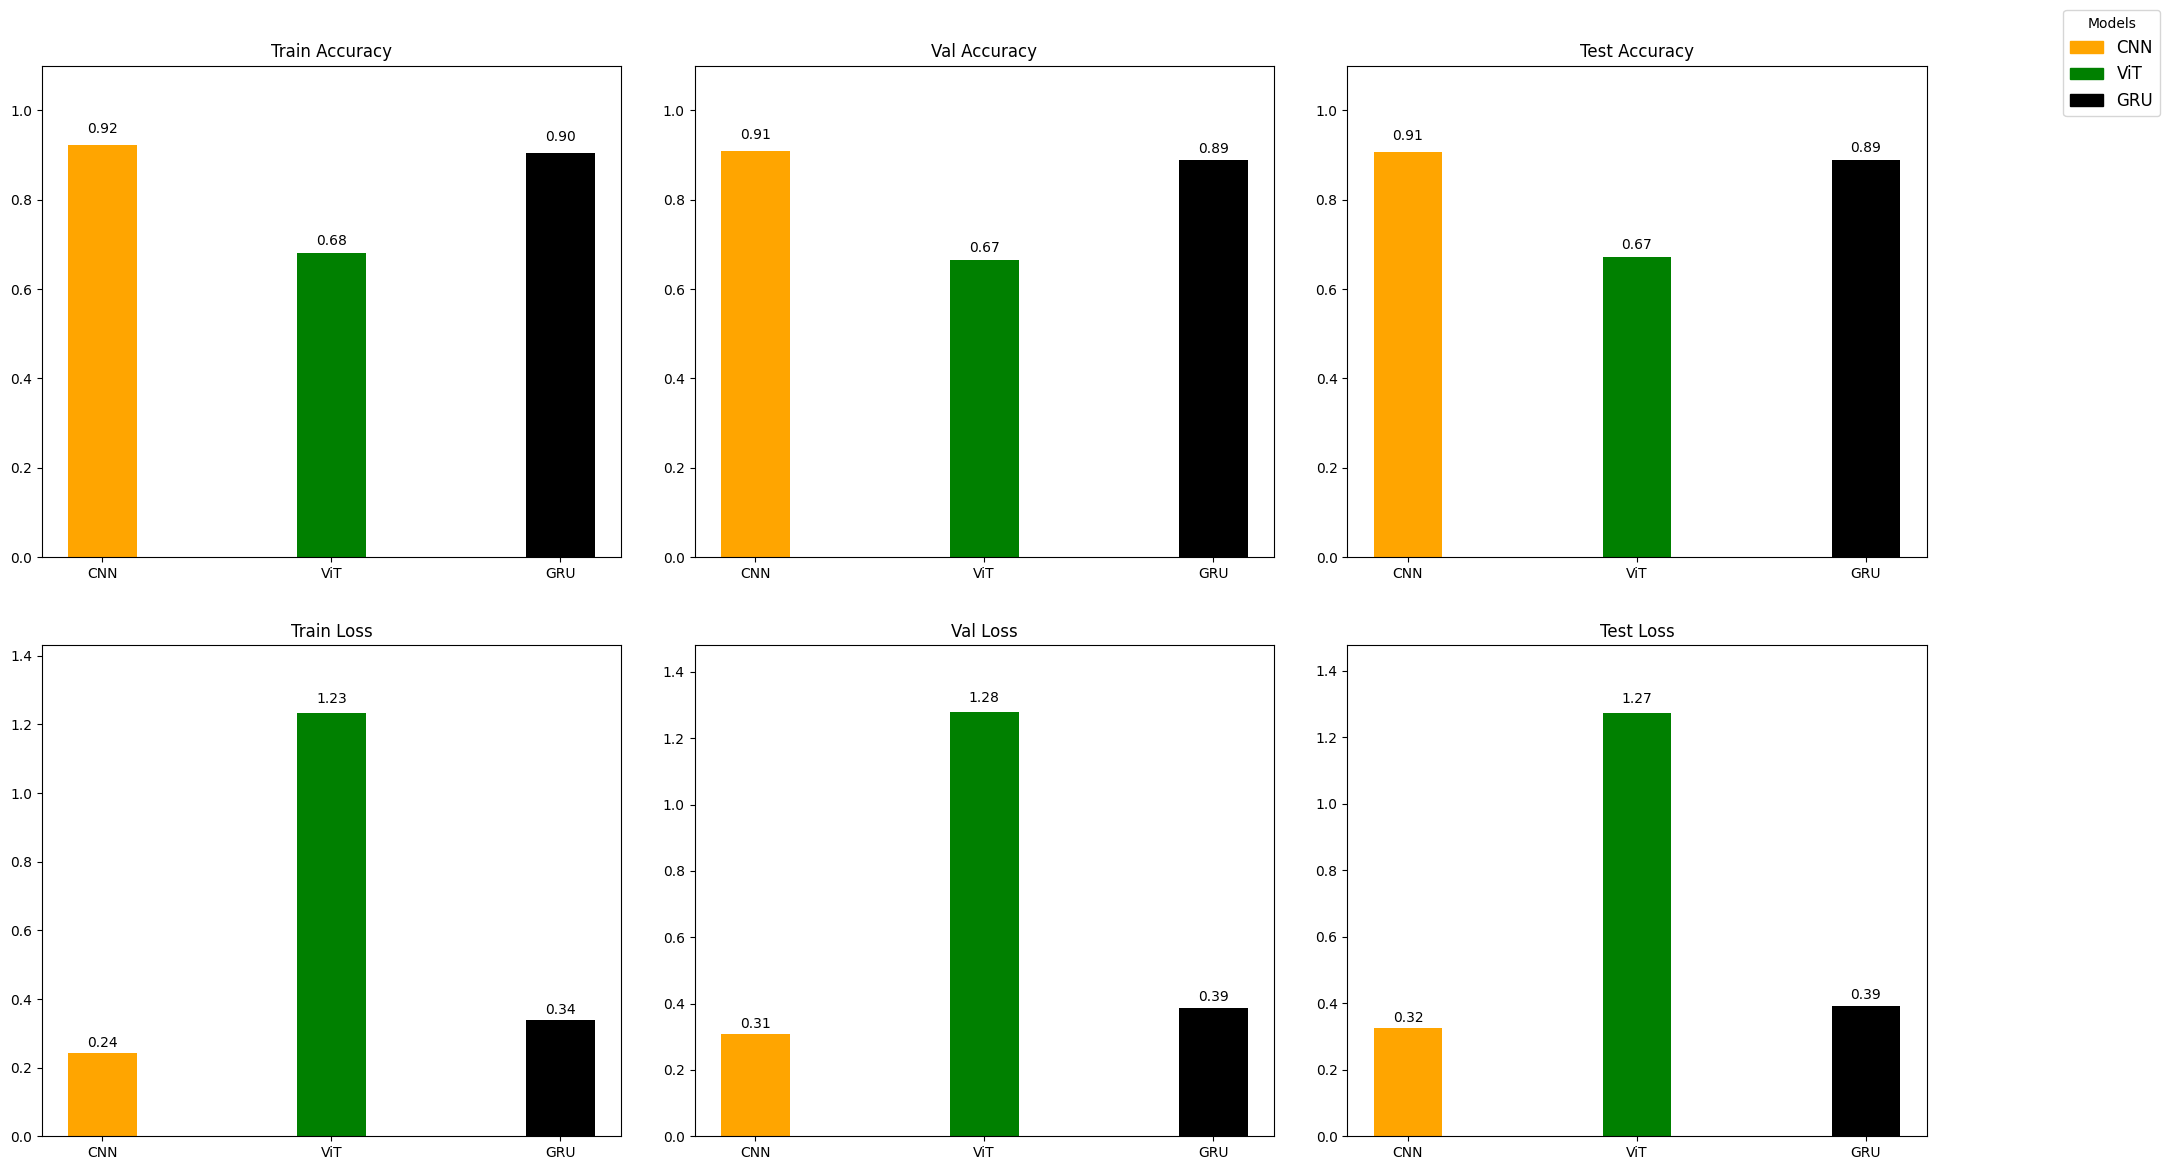

In [26]:
plot_results(all_results)

## Final Average of Results

In [28]:
# Print final average results
def print_final_averages(all_results):
    print("\n" + "="*50)
    print("Final Average Results")
    print("="*50)
    for model in all_results:
        print(f"\n{model} Model:")
        print(f"Train Accuracy: {np.mean(all_results[model]['train_acc']):.4f}")
        print(f"Val Accuracy: {np.mean(all_results[model]['val_acc']):.4f}")
        print(f"Test Accuracy: {np.mean(all_results[model]['test_acc']):.4f}")
        print(f"Train Loss: {np.mean(all_results[model]['train_loss']):.4f}")
        print(f"Val Loss: {np.mean(all_results[model]['val_loss']):.4f}")
        print(f"Test Loss: {np.mean(all_results[model]['test_loss']):.4f}")

In [29]:
print_final_averages(all_results)


Final Average Results

CNN Model:
Train Accuracy: 0.9223
Val Accuracy: 0.9093
Test Accuracy: 0.9066
Train Loss: 0.2419
Val Loss: 0.3076
Test Loss: 0.3249

ViT Model:
Train Accuracy: 0.6815
Val Accuracy: 0.6653
Test Accuracy: 0.6721
Train Loss: 1.2341
Val Loss: 1.2798
Test Loss: 1.2739

GRU Model:
Train Accuracy: 0.9049
Val Accuracy: 0.8880
Test Accuracy: 0.8892
Train Loss: 0.3387
Val Loss: 0.3882
Test Loss: 0.3926
